When it comes to applying neural networks to Time Series processing (or other kind of sequential data), first words that we'll probably think of are **recurrent** and **convolutional** layers. That's absolutely right! In this post we'll pass, step-by-step, through one of the simpliest examples of convolutional layer application i.e. training network to compute moving average. Such example may seem to not be practical, however its simplicity allows us to trace whole process and understand, how to control network's behaviour, to model the way the network works.

### 1. Downloading the data 
First thing we have to do is to download or create fake time serie dataset. Let get a Shampoo sales dataset published by Rob Hyndman in his **R package** `fma` (which was a software appedix for the book *Forecasting: Methods and Applications*). Originally this dataset can be found inside R script, but as we work with a Python libary PyTorch, it be better for us to load this data from csv file. Such file can be found, for instance, [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv). Supposing we work in **Jupyter Notebook** on Linux, we can fetch this data running following command:

In [1]:
## Download dataset
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

### 2. Loading data and simple visualization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

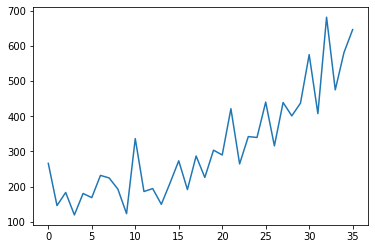

In [3]:
data = pd.read_csv("shampoo.csv")
plt.plot(data['Sales'])
plt.show()         

In this plot we can see an increasing trend, but in this excercise, data characterics make no diffeence for us.

### 3. 1-d convolution in PyTorch: lightning-quick intro (or reminder)

In the case of **univariate time series**, one-dimensional convolution is a sliding window applied over time series, an operation which consist of multiplications and additions. It was intuitively illustrated on the gif below.

<img src="conv1d.gif" width="400">
Source: https://blog.floydhub.com/reading-minds-with-deep-learning/

As you can see, output depend on input and **kernel** values. Defining proper kernel, we can apply the operation we want. For example, using a **(0.5, 0.5)** kernel, it will give us a two-element moving average. To test that, let's do a simple experiment.

### 4. Computing moving average with `pandas`

In [8]:
ts = data.Sales
ts.head(10)

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
5    168.5
6    231.8
7    224.5
8    192.8
9    122.9
Name: Sales, dtype: float64

Using `pandas`, we can compute moving average by combining `rolling` and `mean` method calls. We use `head` method as well, to limit the output. By the way, this example shows the object-oriented nature of `pandas`, which allows us to chain following methodc calls. Other fact that is worth to mention is a **NaN** occurrence in the first row. It's because we can't compute moving avearge for the first element if we haven't added any padding on the beginnng of the array; moreover, `pandas` keeps the input's length, so the first element has no value. 

In [9]:
# rolling(2) means that we use a sliding window of length 2
ts.rolling(2).mean().head(10)

0       NaN
1    205.95
2    164.50
3    151.20
4    149.80
5    174.40
6    200.15
7    228.15
8    208.65
9    157.85
Name: Sales, dtype: float64

### 5. Computing moving average with PyTorch

Now, let's reproduce this result using 1-dimensional convolution from PyTorch. 

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [14]:
print(len(ts))

36


In [13]:
ts_tensor = torch.Tensor(ts).reshape(1, 1, -1)

Let's stop here for a moment. If you are not familiar with deep learning frameworks, you would be quite confused because of this `reshape` operation. What did we do above? We created a **3-dimensional tensor**; each number in `reshape` function describes respectively:

1. number of samples
2. number of channels
3. length of time series

Meaning of this values requires some explanation.

1. **Number of samples** is the number of time series we are working on. As we want to perform computations for one time series only, the value must equal one.
2. **Number of channels** is is the number of **features** or (independent) **variables**. We don't have any parallel variables contaning information about, say, temperature or population. It's clear that this value must equal one too.
3. **Length of time series**. Accordingly to Python tensor reshaping convention, minus one means *infer value for this dimension*. If one-dimensional time series length has 36 elements, after reshaping it to three-dimensional tensor with *number_of_samples* = 1 and *number_of_channels* = 1, the last value will be equal to 36.

We have to do the same with the kernel.

In [18]:
kernel = [0.5, 0.5]
kernel_tensor = torch.Tensor(kernel).reshape(1, 1, -1) 

In [9]:
F.conv1d(ts_tensor, kernel_tensor)

tensor([[[205.9500, 164.5000, 151.2000, 149.8000, 174.4000, 200.1500, 228.1500,
          208.6500, 157.8500, 229.7000, 261.2000, 190.1000, 171.9000, 179.8000,
          241.7000, 232.3500, 239.2000, 256.5000, 264.8000, 296.7500, 355.7500,
          343.0500, 303.4000, 341.0000, 390.0500, 378.1500, 377.6000, 420.3000,
          419.3500, 506.4500, 491.5500, 544.8000, 578.6500, 528.3000, 614.1000]]])

As we can observe, the result is identical with values returned by `pandas` methods. The only difference is lack of **NaN** on the beginning.

### 6. Learning a network, which computes moving average

Now, let's get to the point and train the network on the fully controllable example. I've called in this manner to distinguish it from the real-life ones. In most cases, when we train a machine learning model, we don't know the optimal parameter values. We are just trying to choose the best ones, but have no guarantee that they are globally optimal. Here, the optimal kernel value is known and should equal **[0.2, 0.2, 0.2, 0.2, 0.2]**.

In [35]:
X = data.Sales
X_tensor = torch.Tensor(X).reshape(1,1,-1)

In the step below, we are preparing **targets** (**labels**), which equals to the five-element moving average.

In [36]:
y = data.Sales.rolling(5).mean()
y = y[4:, ].to_numpy()
y_tensor = torch.Tensor(y).reshape(1,1,-1)
y_tensor

tensor([[[178.9200, 159.4200, 176.6000, 184.8800, 199.5800, 188.1000, 221.7000,
          212.5200, 206.4800, 197.8200, 215.2600, 202.6200, 203.7200, 222.2600,
          237.5600, 256.2600, 259.5800, 305.6200, 301.1200, 324.3800, 331.6000,
          361.7000, 340.5600, 375.5200, 387.3200, 406.8600, 433.8800, 452.2200,
          500.7600, 515.5600, 544.3400, 558.6200]]])

We are building a one-layer convlutional neural network. It's good to highlight, that **we don't use any nonlinear activation function**. Last numerical value describes the length of the kernel, *padding_mode = 'valid'* means that we don't add any padding to the input, so we have to expect that output will be "trimmed". 

In [42]:
# Building a network
net = nn.Conv1d(1, 1, 5, padding_mode = "valid", bias = False)

Kernel is already initialized with, assume it for simplicity, *random* values. 

In [43]:
# Initial values
net.weight.data.numpy()

array([[[-0.26035744, -0.03702363,  0.36730862, -0.02416185,
          0.13382941]]], dtype=float32)

We can perfom a convolution operation using this random value, calling **net.forward()** or simply **net()** (because Conv1d layer is a [callable object](https://stackoverflow.com/questions/5824881/python-call-special-method-practical-example/5826283)). This two operations are equivalent.

In [44]:
net(X_tensor)

tensor([[[ 13.8443,  17.2486,  41.0878,  48.5995,  52.3392,  41.7977,  44.2186,
           -3.6977,  90.3636,  39.1391,   1.3805,  30.8177,  40.0606,  87.4678,
           28.7942,  62.3456,  54.0152,  77.8429,  61.6129, 104.4986,  43.2576,
           56.9010,  74.8728, 111.2240,  54.3756,  83.8423, 115.3400,  72.0719,
          172.1338,  61.6583, 151.8888, 115.7389]]],
       grad_fn=<SqueezeBackward1>)

We are initializing an optimizer object. I highly encourage you to experiment and start with **SGD** which may do not converge.

In [45]:
# Training a network
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.01)

Here, he have only one example so it does not make sense to divide training into epochs

In [46]:
running_loss = 0.0
for iteration in range(1001):
    # Zeroing gradients. For more, 
    # see: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    optimizer.zero_grad()
    
    # Forward propagation
    outputs = net(X_tensor)  
    
    # Mean squared error
    loss_value = torch.mean((outputs - y_tensor)**2)
    
    # Computing gradients
    loss_value.backward()
    
    # Changing network parameters with optimizer
    optimizer.step()
    
    # Extractin loss value from tensor
    running_loss += loss_value.item()
    
    if iteration % 50 == 0:
        print('[%d] loss: %.3f' % (iteration, loss_value.item()))
        print(net.weight.data.numpy())
    

[0] loss: 65233.992
[[[-0.25035745 -0.02702364  0.3773086  -0.01416185  0.14382942]]]
[50] loss: 766.905
[[[-0.10564941  0.11878491  0.5043409   0.1344783   0.27711937]]]
[100] loss: 543.447
[[[-0.0883443   0.13628373  0.48577502  0.15751141  0.2710214 ]]]
[150] loss: 426.048
[[[-0.0724933   0.14859414  0.45826674  0.1760565   0.25820443]]]
[200] loss: 328.581
[[[-0.05417605  0.15856615  0.4295487   0.1921131   0.2450627 ]]]
[250] loss: 251.294
[[[-0.03332883  0.1663786   0.40218312  0.20528159  0.23343563]]]
[300] loss: 191.313
[[[-0.01093305  0.17196906  0.37692106  0.21512112  0.2236998 ]]]
[350] loss: 144.881
[[[0.01206546 0.17570996 0.3540248  0.22179407 0.21593276]]]
[400] loss: 108.854
[[[0.03480669 0.1781194  0.33345547 0.225752   0.2099969 ]]]
[450] loss: 80.925
[[[0.05659157 0.17970598 0.3150443  0.2275533  0.2056486 ]]]
[500] loss: 59.412
[[[0.07691177 0.18088101 0.29859436 0.22774552 0.20260815]]]
[550] loss: 43.023
[[[0.09544624 0.18192899 0.28392747 0.2268057  0.20060207]

As we can see in this example, algorithm converges and parameter values are becoming close to the **true solution**, i.e. 
**[0.2, 0.2, 0.2, 0.2, 0.2]**.